In [2]:
import multiprocessing
import random
from math import comb

import numpy as np
from matplotlib import pyplot as plt
from scipy.special import gamma

SAVE_FIGURES = True

Task 9
Let $0 \lt q \lt \frac{1}{2}$ represent the __probability of the adversary mining the next block__ and let this probability correspond to the fraction of computational power he/she possess. Let $n$ represent the number of confirmations (mined blocks) needed to consider a transaction as confirmed. Let $P(n, q)$ represent the probability that an adversary with power $q$ will mine a chain of blocks equal to or longer than the one mined by honest users at the moment when they have attached to the block containing the considered transaction $n$ blocks, or ever after.

### Model:
$T$ -- time required for generation of the next block:
- $T \sim Exp(\lambda)$
- $f_T(t) = \alpha e^{-\alpha t}$, $\alpha > 0$
- $E(T) = \frac{1}{\alpha}$

$T_k$ -- time required for generation of the $k$-th block
- $T_1, T_2, \dots$ -- independent random variables

$S_n = T_1 + T_2 + \dots + T_n$ -- time required for generation of $n$ blocks
- $S_n \sim Gamma(n, \alpha)$
- $F_{S_n}(t) = 1 - e^{-\alpha t} \sum_{k = 0}^{n - 1} \frac{(\alpha t)^k}{k!}$

$N(t) = \max\{n: S_n \leq t\}$ -- number of blocks generated by time $t$
- $S_0 = 0$
- $N(t) \Leftrightarrow	S_n \leq t \land S_{n + 1} \gt t$
- $P[N(t) = n] = P[S_n \leq t \land S_{n + 1} \gt t] = P[S_n \leq t] - P[S_{n + 1} \leq t] = F_{S_n}(t) - F_{S_{n + 1}}(t) = \frac{(\alpha t)^n}{n!}e^{-\alpha t}$
- $N(t) \sim Pois(\alpha n)$
- taking all of that into consideration, we can say that $\{N(t), t \geq 0\}$ is a Poisson process with intesity parameter $\alpha$.

### Race with the adversary:
- $T, S_n, N(t)$ -- for legitimate user
- $T', S'_n, N'(t)$ -- for adversary
- $T \sim Exp(\alpha)$ and $T' \sim Exp(\alpha')$, where $\alpha, \alpha'$ denote the computational power of the legitimate user and the adversary respectively.
- $M = min(T, T') \sim Exp(\alpha + \alpha')$
- $P[T \lt T'] = \frac{\alpha}{\alpha + \alpha'}$, thus
- $p=\frac{\alpha}{\alpha + \alpha'}$ and $q = \frac{\alpha'}{\alpha + \alpha'}$, where $p$ and $q$ denote the probability of the legitimate user and the adversary respectively.
- Typically in blockchain network it is desired to have fixed expected time for new block generation, let's call it $\tau = \frac{1}{\alpha + \alpha'}$.
$$E[T] = \frac{1}{\alpha} = \frac{\tau}{p}$$
$$E[T'] = \frac{1}{\alpha'} = \frac{\tau}{q}$$
- $E_n$ -- event of adversary of catching up with the legitimate user after $n$ blocks, let's denote probability of that event with $q_n$. $$P[E_n] = q_n = (\frac{q}{p})^n$$




### Nakamoto:
Let's denote probability of adversary caching up with the longest chain after they appended $n$ blocks or more by $P(n)$.

$$ P(n) = P[N'(S_n) \gt n] + \sum^n_{k=0}P[N'(S_n) = k] \cdot q_{n-k}. $$

Nakamoto uses the following, $N'(S_n)$ is approximated with $N'(E[S_n])$, where $E[S_n] = nE[T] = n\frac{\tau}{p}$.

$N'(E[S_n]) \sim Pois(\lambda)$, where $$\lambda = \alpha' E[S_n] = \alpha' \frac{n\tau}{p} = \frac{n q}{p}, $$ so

$$ P[N'(S_n) = k] = e^{- \lambda} \frac{\lambda^k}{k!}. $$

Notice that $q_0 = 1$, so considering all things above we can say that:

$$P(n) \approx P[N'(E[S_n]) \gt n] + \sum^n_{k=0} P[N'(E[S_n]) = k] \cdot q_{n-k} $$

$$ = 1 - \sum^n_{k=0} P[N'(E[S_n]) = k] + \sum^n_{k=0} P[N'(E[S_n]) = k] \cdot q_{n-k} $$

$$ = 1 - \sum^{n-1}_{k=0} P[N'(E[S_n]) = k] \cdot (1 - q_{n-k}) $$

$$ = 1 - \sum^{n-1}_{k=0} e^{- \lambda} \frac{\lambda^k}{k!} (1 - q_{n-k}) $$

### Grunspan:
Let $X_n$ be random variable representing number of blocks mined by the adversary at the moment when onset miners appended $n$ blocks to the longest chain. Then $X_n \sim NegBin(n, p)$

$$ P[X_n = k] = p^n q^k \binom{k + n - 1}{k} $$ and

$$ P[X_n < k] = \sum^{k}_{l=0} (p^n q^l) \binom{l + n - 1}{l}. $$

Let redefine $P(n)$ without $N'(S_n) = N'(E[S_n])$ assumption using Grunspan's approach:

$$ P(n) = 1 - \sum^{n-1}_{k=0} (p^n q^k - q^n p^k) \binom{k + n - 1}{k}. $$

__a)__ Compare the formulas for $P(n, q)$ obtained by Nakamoto and Grunspan. In particular:
− set $n = 1, 3, 6, 12, 24, 48$ and plot $P(n, q)$ depending on the value of $q$,
− set the acceptable probability of adversary success $P(n, q) = 0.1\%, 1\%, 10\%$ and draw graphs showing how to choose the value of $n$ depending on the value of $q$.

$$ P_{nakamoto}(n) = 1 - \sum^{n-1}_{k=0} e^{- \lambda} \frac{\lambda^k}{k!} (1 - q_{n-k}) $$

$$ P_{grunspan}(n) = 1 - \sum^{n-1}_{k=0} (p^n q^k - q^n p^k) \binom{k + n - 1}{k}. $$


In [76]:
def P_nakamoto(n: int, q: float):
    p = 1 - q
    lambda_ = n * q / p
    return 1 - np.sum([np.exp(-lambda_) * lambda_ ** k / gamma(k + 1) * (1 - (q / p) ** (n - k)) for k in range(n)])


def P_grunspan(n: int, q: float):
    p = 1 - q
    return 1 - np.sum([(p ** n * q ** k - q ** n * p ** k) * float(comb(k + n - 1, k)) for k in range(n)])

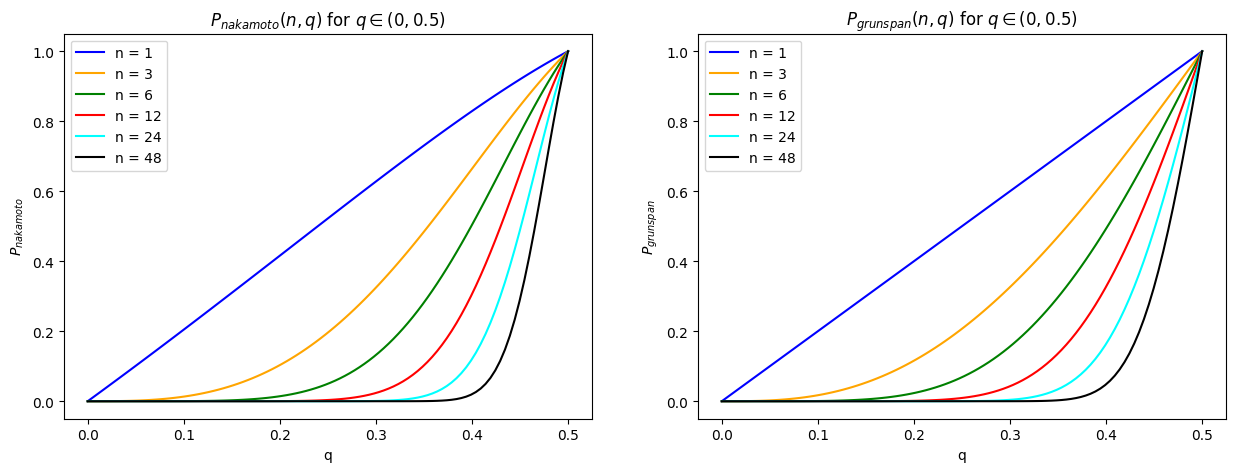

In [36]:
def subtask_a_1():
    colors = ['blue', 'orange', 'green', 'red', 'cyan', 'black']
    q_linspace = np.linspace(0, 0.5, 100)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for i, n in enumerate([1, 3, 6, 12, 24, 48]):
        axs[0].plot(q_linspace, [P_nakamoto(n, q) for q in q_linspace], label=f'n = {n}', color=colors[i])
        axs[1].plot(q_linspace, [P_grunspan(n, q) for q in q_linspace], label=f'n = {n}', color=colors[i])

    axs[0].set_title(r'$P_{nakamoto}(n, q)$ for $q \in (0, 0.5)$')
    axs[0].set_ylabel(r'$P_{nakamoto}$')
    axs[1].set_title(r'$P_{grunspan}(n, q)$ for $q \in (0, 0.5)$')
    axs[1].set_ylabel(r'$P_{grunspan}$')

    for ax in axs:
        ax.legend()
        ax.set_xlabel('q')

    if SAVE_FIGURES is True:
        plt.savefig('figures/subtask_a_1.png')
    plt.show()

subtask_a_1()

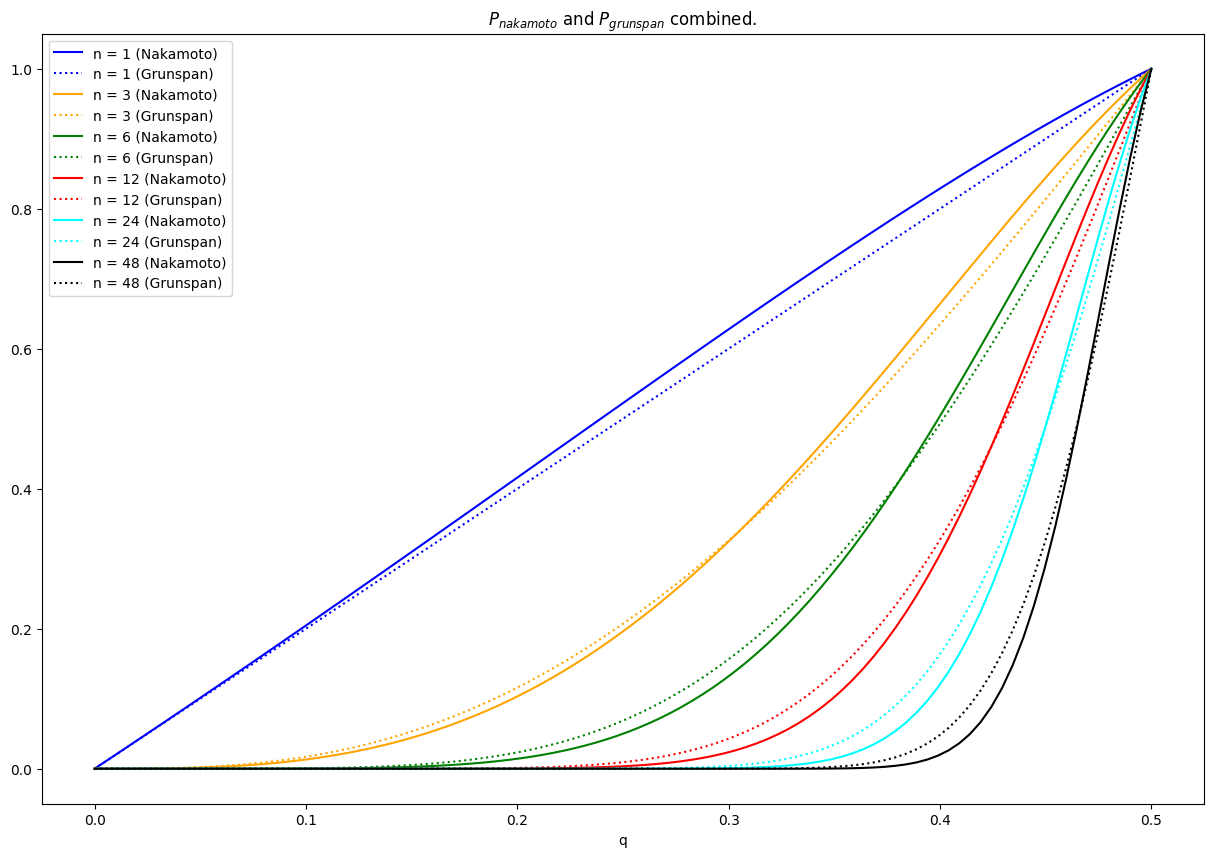

In [51]:
def subtask_a_1_combined():
    colors = ['blue', 'orange', 'green', 'red', 'cyan', 'black']
    q_linspace = np.linspace(0, 0.5, 100)
    fig, ax = plt.subplots(figsize=(15, 10))
    for i, n in enumerate([1, 3, 6, 12, 24, 48]):
        ax.plot(q_linspace, [P_nakamoto(n, q) for q in q_linspace], label=f'n = {n} (Nakamoto)', color=colors[i],
                linestyle='solid')
        ax.plot(q_linspace, [P_grunspan(n, q) for q in q_linspace], label=f'n = {n} (Grunspan)', color=colors[i],
                linestyle='dotted')
    ax.set_title(r'$P_{nakamoto}$ and $P_{grunspan}$ combined.')
    ax.legend()
    ax.set_xlabel('q')
    ax.set_ylabel('P')

    if SAVE_FIGURES is True:
        plt.savefig('figures/subtask_a_1_combined.png')
    plt.show()


subtask_a_1_combined()

/tmp/ipykernel_74581/187977298.py:4: RuntimeWarning: overflow encountered in scalar power
  return 1 - np.sum([np.exp(-lambda_) * lambda_ ** k / gamma(k + 1) * (1 - (q / p) ** (n - k)) for k in range(n)])


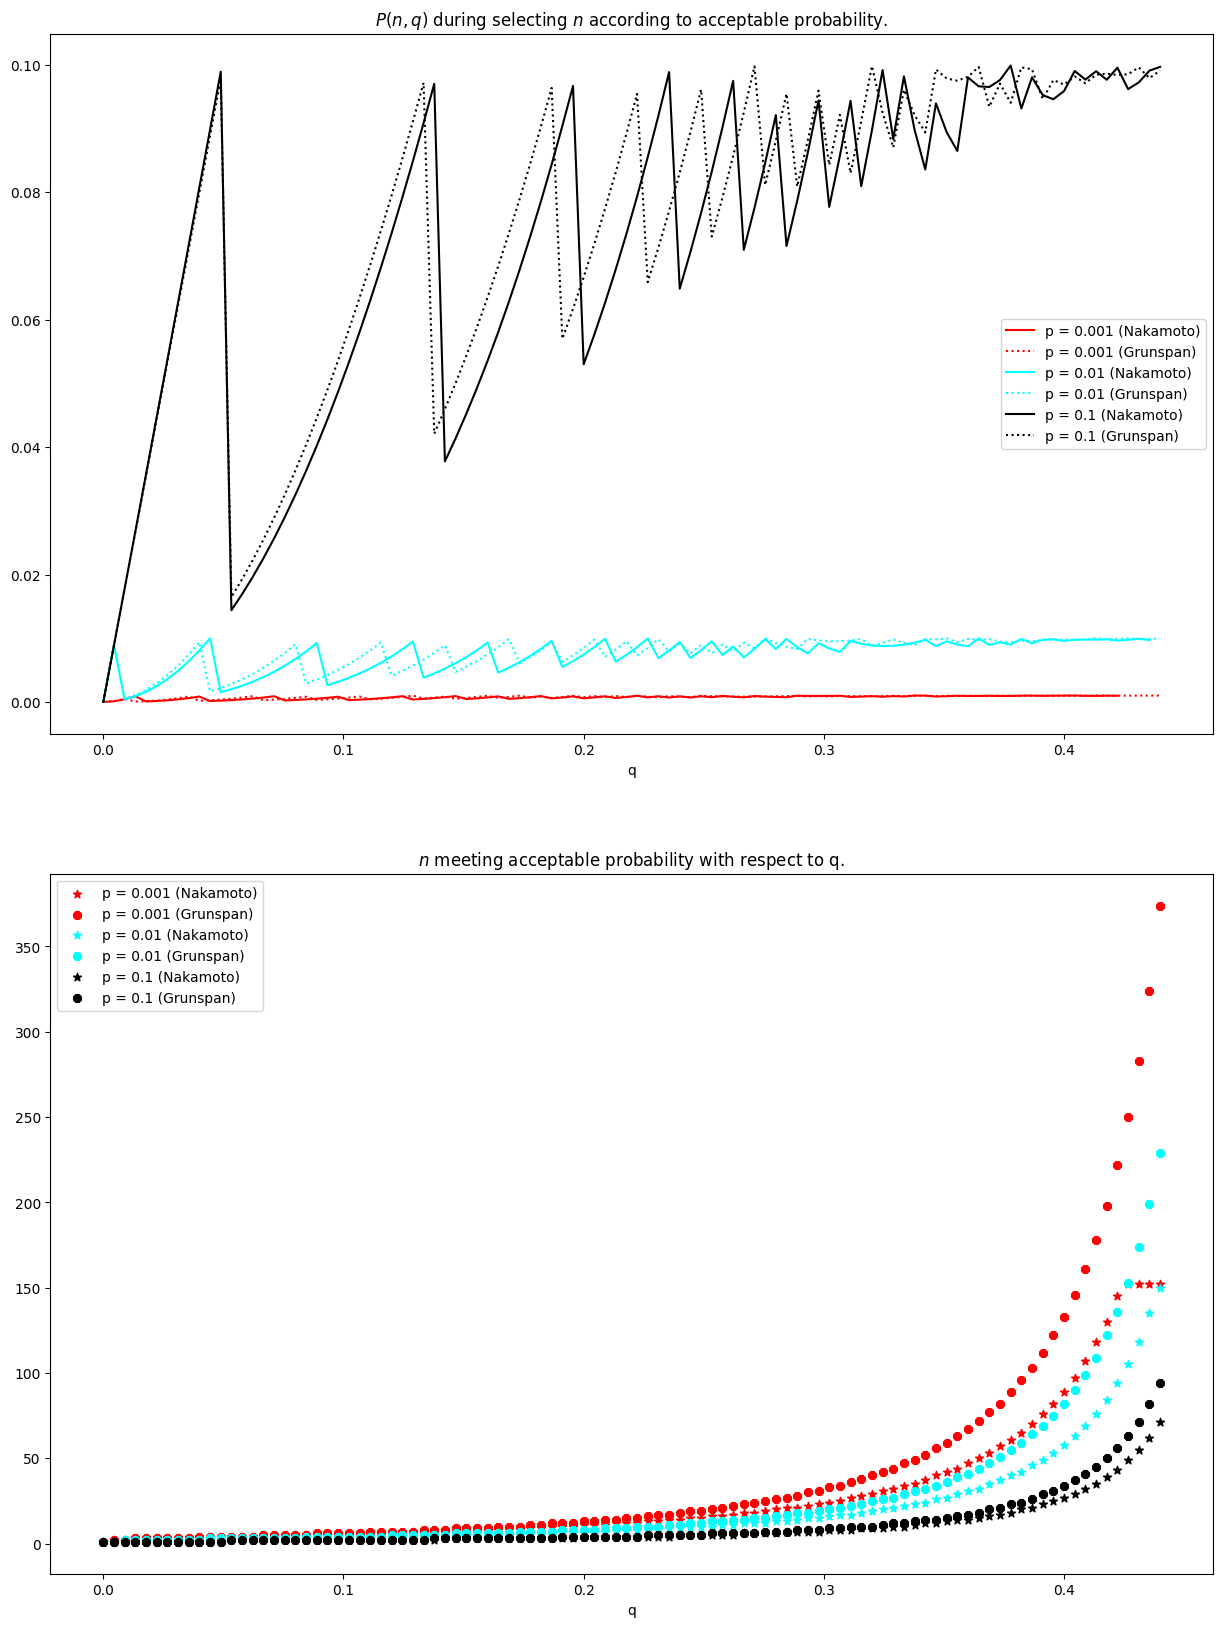

In [59]:
def subtask_a_2():
    colors = ['red', 'cyan', 'black']
    fig, axs = plt.subplots(2, 1, figsize=(15, 20))

    q_linspace = np.linspace(0, 0.44, 100)  # problem with overflow for q > 0.44
    for i, acceptable_probability in enumerate([0.001, 0.01, 0.1]):
        p_nak_linspace, p_grun_linspace = [], []
        n_nak_linspace, n_grun_linspace = [], []
        n_nak, n_grun = 1, 1
        for q in q_linspace:
            while P_nakamoto(n_nak, q) > acceptable_probability:
                n_nak += 1
            p_nak_linspace.append(P_nakamoto(n_nak, q))
            n_nak_linspace.append(n_nak)

            while P_grunspan(n_grun, q) > acceptable_probability:
                n_grun += 1
            p_grun_linspace.append(P_grunspan(n_grun, q))
            n_grun_linspace.append(n_grun)

        axs[0].plot(q_linspace, p_nak_linspace, label=f'p = {acceptable_probability} (Nakamoto)', color=colors[i],
                    linestyle='solid')
        axs[0].plot(q_linspace, p_grun_linspace, label=f'p = {acceptable_probability} (Grunspan)', color=colors[i],
                    linestyle='dotted')

        axs[1].scatter(q_linspace, n_nak_linspace, label=f'p = {acceptable_probability} (Nakamoto)', color=colors[i],
                       marker="*")
        axs[1].scatter(q_linspace, n_grun_linspace, label=f'p = {acceptable_probability} (Grunspan)', color=colors[i],
                       marker='8')

    axs[0].set_title(r'$P(n, q)$ during selecting $n$ according to acceptable probability.')
    axs[0].set_ylabel('P')
    axs[1].set_title(r'$n$ meeting acceptable probability with respect to q.')
    axs[1].set_ylabel('n')

    for ax in axs:
        ax.legend()
        ax.set_xlabel('q')
    plt.show()


subtask_a_2()

__b)__ Implement a *double spending attack* simulator, which will enable experimental approximation of the probability $P(n, q)$ depending on the values of $n$ and $q$.

__Hint__: design the experiment and repeat it multiple times (_Monte Carlo method_). <u>Carefully and thoroughly describe the idea and code of the simulator.</u>

In [97]:
def single_double_spending_experiment(n: int, q: float, settlement_lag_acceptance_const: int = 30) -> int:
    current_distance = n
    while current_distance > 0:
        if random.random() < q:
            current_distance -= 1
        else:
            current_distance += 1
        if current_distance >= settlement_lag_acceptance_const * n:
            return 0
    return 1


def P_monte_carlo(n: int, q: float, num_experiments: int = 1000, num_threads: int = 8) -> float:
    # Create a multiprocessing pool with the `num_threads` threads
    with multiprocessing.Pool(processes=num_threads) as pool:
        prob_of_success_double_spending = sum(
            pool.starmap(single_double_spending_experiment, [(n, q) for _ in range(num_experiments)])) / num_experiments

    # Return the results of the experiments
    return prob_of_success_double_spending


In [98]:
%%time
results = P_monte_carlo(n=12, q=0.5)
print(results)

0.96
CPU times: user 2.04 ms, sys: 70.6 ms, total: 72.7 ms
Wall time: 304 ms


Process ForkPoolWorker-9897:
Process ForkPoolWorker-9901:
Process ForkPoolWorker-9899:
Process ForkPoolWorker-9898:
Process ForkPoolWorker-9903:
Process ForkPoolWorker-9902:


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f1d4fb82dd0> (for post_execute):


KeyboardInterrupt: 

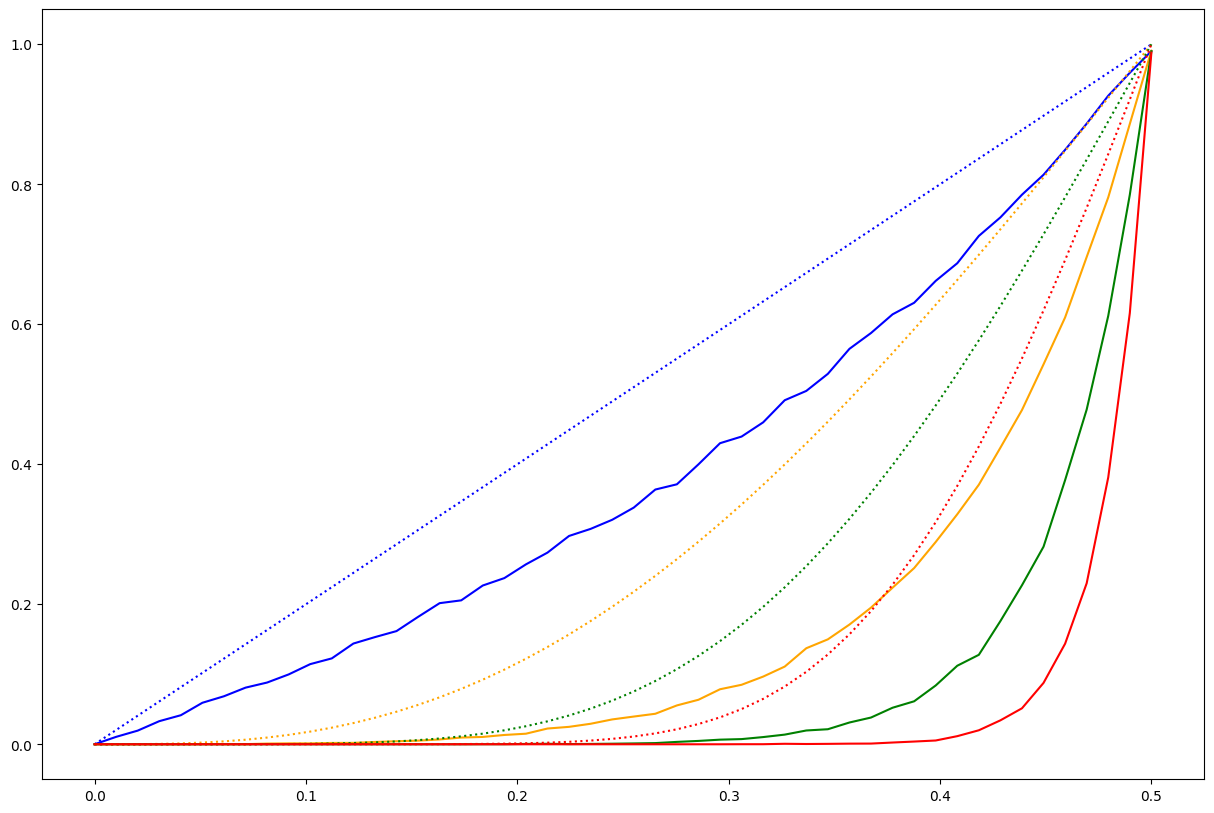

In [88]:
def subtask_b():
    colors = ['blue', 'orange', 'green', 'red', 'cyan', 'black']
    q_linspace = np.linspace(0, 0.5, 50)
    fig, ax = plt.subplots(figsize=(15, 10))
    for i, n in enumerate([1, 3, 6, 12, 24, 48]):
        ax.plot(q_linspace, [P_monte_carlo(n, q) for q in q_linspace], label=f'n = {n} (Monte Carlo)', color=colors[i],
                linestyle='solid')
        ax.plot(q_linspace, [P_nakamoto(n, q) for q in q_linspace], label=f'n = {n} (Nakamoto)', color=colors[i],
                linestyle='dashed')
        ax.plot(q_linspace, [P_grunspan(n, q) for q in q_linspace], label=f'n = {n} (Grunspan)', color=colors[i],
                linestyle='dotted')
    ax.set_title(r"Monte Carlo method for double spending attack with comparison to $P_{nakamoto}$ and $P_{grunspan}$.")
    ax.legend()
    ax.set_xlabel('q')
    ax.set_ylabel('P')

    if SAVE_FIGURES is True:
        plt.savefig('figures/subtask_b.png')
    plt.show()


subtask_b()

__c)__ Compare the _simulator results_ to the _analytical results_ (__graphs__). If there are discrepancies, try to explain them.

Inaccuracy is due to the fact that during Monte Carlo simulation we have to create and upper exit condition. I chose to make it depend on length of so far appended blocks times some constant ($\texttt{n} \cdot \texttt{settlement_lag_acceptance_const}$). This is due to the fact that in Monte Carlo simulation we are not able to simulate infinite number of blocks, so we have to make some upper bound. This bound is not perfect, but it is good enough to show that the probability of double spending attack is decreasing with increasing number of starting blocks.